<font size="5">Section 6: Structural Equation Modelling</font>

## Housekeeping and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
import linearmodels.panel as lmp
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
import semopy 
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA

%matplotlib inline

First, we simulate some data to use all different methods. Nine continuous variables and nine binary variables, all with different levels of correlation among them.

In [2]:
# experiment parameters
np.random.seed(123) #set seed
nsize = 10000

# variance-covariance matrix (simetric)
cov = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# correlated variables 
X = norm.rvs(size=(3, nsize))
evals, evecs = eigh(cov)
c = np.dot(evecs, np.diag(np.sqrt(evals)))
Xa = np.dot(c, X)
Xa = Xa.transpose()
X = X.transpose()
X = pd.DataFrame(X)
Xa = pd.DataFrame(Xa)
Xc = pd.DataFrame(np.c_[X,Xa], columns=['X1','X2','X3','X4','X5','X6'])
Xc['X7'] = Xc['X2'] + Xc['X5']
Xc['X8'] = Xc['X1'] + Xc['X5'] 
Xc['X9'] = Xc['X2'] + Xc['X6'] 

# binary variables based of continous variables
Xb = pd.DataFrame()
for col in Xc:
  Xb[col] = pd.qcut(Xc[col], 2, [0,1])

#data description
Xb.describe()


,X1,X2,X3,X4,X5,X6,X7,X8,X9
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0
freq,5000,5000,5000,5000,5000,5000,5000,5000,5000


<AxesSubplot:>

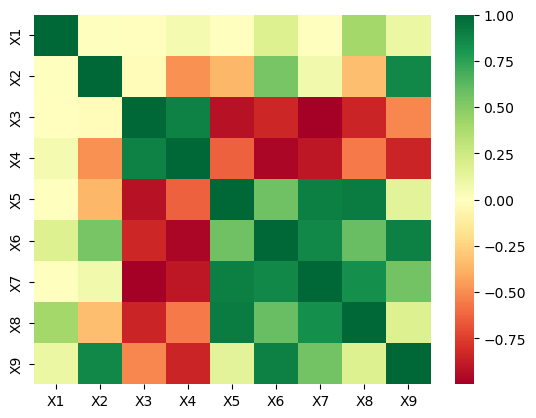

In [61]:
sns.heatmap(Xc.corr(), cmap='RdYlGn') 

## PCA

PCA for continous variables in this example using sklearn. We can select the number of components to be estimated or use *'mle'* to determine the optimal number of eigenvalues based on the variance of the data.

Then we can report the Scree Plot that shows the percentage of variance that each component contributes. Based on the results, the data can be summarized using three components.

Finally, we can use the estimated components and transform them into a data frame. We can also show that, by construction, the components are orthogonal (zero covariance).

In [164]:
pca = PCA(n_components=8)
pca_features = pca.fit_transform(Xc)
print(pca.explained_variance_ratio_)

[7.09045589e-01 2.29130561e-01 6.18238492e-02 2.43460183e-32
 1.05077704e-32 2.92445943e-33 1.25306650e-33 7.05883071e-34]


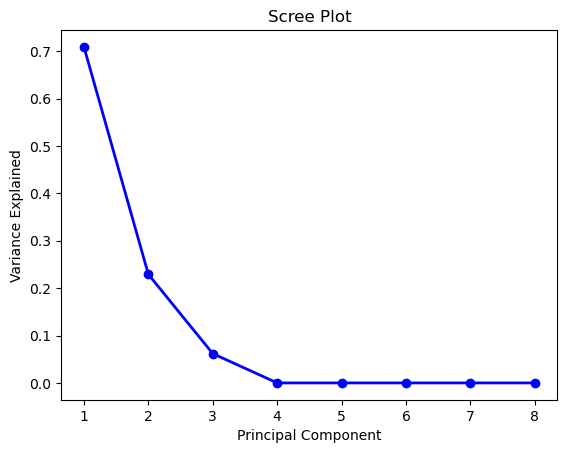

In [165]:
#scree plot using explained variance proportion

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [166]:
pca = PCA(n_components='mle')
pca_features = pca.fit_transform(Xc)
print(pca.explained_variance_ratio_)

[0.70904559 0.22913056 0.06182385]


In [167]:
pca_vectors = pd.DataFrame(data = pca.components_)
pca_vectors.head()

,0,1,2,3,4,5,6,7,8
0,0.031173,0.003378,-0.222667,-0.361357,0.479615,0.215838,0.482992,0.510787,0.219216
1,-0.047268,0.395973,-0.011061,-0.364311,-0.332058,0.232996,0.063916,-0.379326,0.628970
2,0.752066,0.094902,0.100046,0.170788,-0.295688,0.103681,-0.200787,0.456378,0.198583


In [168]:
pca_df = pd.DataFrame(data=pca_features,columns=['PC1', 'PC2', 'PC3'])
pca_df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,PC1,PC2,PC3
count,10000.000,10000.000,10000.000
mean,0.000,0.000,-0.000
std,4.419,2.512,1.305
min,-15.979,-8.920,-4.914
25%,-3.000,-1.730,-0.888
50%,0.017,0.001,0.001
75%,2.973,1.690,0.871
max,16.097,10.243,5.157


In [43]:
pca_df.corr().apply(lambda s: s.apply('{0:.3f}'.format))

,PC1,PC2,PC3
PC1,1.000,0.000,-0.000
PC2,0.000,1.000,-0.000
PC3,-0.000,-0.000,1.000


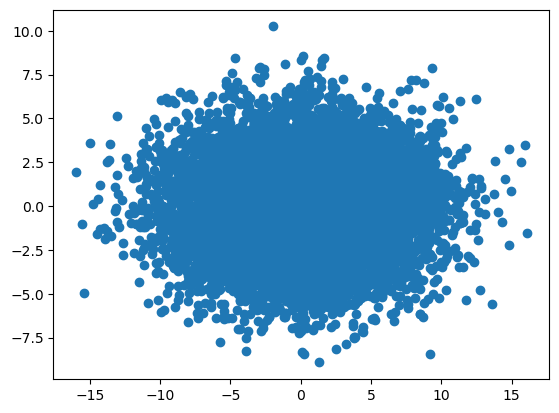

In [169]:
plt.scatter(pca_df['PC1'],pca_df['PC2'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

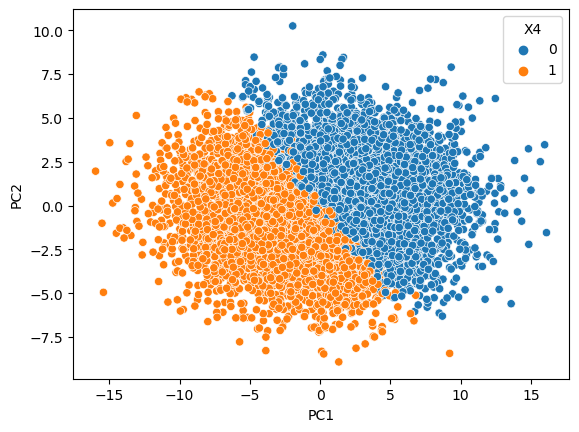

In [84]:
#scatterplot for first two principal factors against binary partition of X4

pca_df['X4'] = 0
pca_df['X4'] = np.where(Xb['X4'] > 0, 1, pca_df['X4'])

sns.scatterplot('PC1', 'PC2', data=pca_df, hue='X4')

## EFA

EFA example using factor_analyzer library. Output shows the factor loadings for each factor, and the eigenvalues, which can be used to construct a scree plot. Number of factors can be chosen or estimated optimally from the data.

Using the semopy library we can also infer which variables belong to each factor, based on the estimated factor loadings (criteria does not restrict unique loadings to each factor). Estimated number of factors chosen optimally base on the data.

Note that semopy yields less factors than factor_analyzer. The difference is due that factor_analyzer reports factors until eigenvalues are irrelevant (variance explained), while semopy presents a potential EFA where all coeficients are statistically significant. In this case, the third factor is mainly only loading to X1 an it contributes to a small proportion of the total explained variance.

Finally semopy reports that the variance-covariance matrix in the dataframe is not positive definite, meaning that some variables are highly correlated (as expected by design), meaning that estimates are likely to be untrustworty. 

In [122]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation='promax')
fa.fit(Xc)

FactorAnalyzer(rotation_kwargs={})

In [123]:
fa.loadings_

array([[-0.03487373,  0.10548121,  1.00328716],
       [-0.44951466,  1.06187463,  0.02031994],
       [-0.96047954, -0.10836013,  0.08990928],
       [-0.62984551, -0.58164478,  0.1333002 ],
       [ 1.06947595, -0.31256919, -0.08802168],
       [ 0.55073345,  0.65903813,  0.10388396],
       [ 0.93675305,  0.15881277, -0.08485118],
       [ 0.96605162, -0.24462346,  0.31648911],
       [ 0.09092536,  0.96582186,  0.07345973]])

In [125]:
fa.get_eigenvalues()

(array([ 5.52726684e+00,  2.33231106e+00,  1.14042210e+00,  8.11050308e-16,
         6.33614691e-16,  1.94542594e-16,  3.77443858e-18, -2.47056753e-16,
        -3.43815490e-16]),
 array([ 5.46469834e+00,  2.49399111e+00,  1.16148033e+00,  2.24660867e-01,
         1.32436425e-01, -1.03781375e-03, -7.49967600e-02, -1.65949678e-01,
        -2.43848259e-01]))

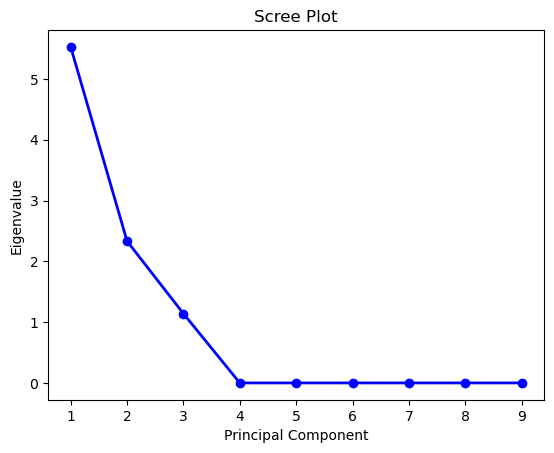

In [126]:
values = np.arange(1,10)
eigenvalues = pd.DataFrame(data=fa.get_eigenvalues())
plt.plot(values, eigenvalues.loc[0], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [127]:
fa.get_factor_variance()

(array([4.78862148, 3.03866133, 1.16415176]),
 array([0.53206905, 0.33762904, 0.1293502 ]),
 array([0.53206905, 0.86969809, 0.99904828]))

EFA example using semopy

In [130]:
print(semopy.efa.explore_cfa_model(Xc, pval=0.05))

eta1 =~ X7 + X3 + X4 + X6 + X5 + X8 + X9
eta2 =~ X6 + X4 + X9 + X5 + X2 + X8



## Latent clases

Latent class analysis not available on Python at this time. Example available in R for the poLCA library at https://rpubs.com/cyanjiner/889802

## Latent growth

Latent growth modelling is not available on Python at this time. Example available in R for the lavaan library at https://lavaan.ugent.be/tutorial/growth.html

Latent trajectory class (growth curves and class membership) is not available on Python at this time. Example available in R for the traj library in class files.

## General CFA

Based on the EFA results we implement a CFA using the semopy library. We declare the model, just as the suggestion in section 3, as a model object, then we declare the model and fit using the data (variable X1 not included since is not used). The output shows the optimized value of the log-likelihood, number of iterations and estimation method used. 

First, note that measurements load into multiple factors, leading to interpretation issues (specially since variables correlate negatively with one factor and positively with the other). Secondly, we observe small covariance between factors, and substatial diferences in the residual error variance across measurements (particularly large error variance in X8). Finally, we can report the fit indices of the model, which allows to compare against alternative specifications in the data.

Also, if you install the graphviz package (and python-graphviz), you can provide a visualization of the estimated model using the semplot function.

In [3]:
Xf=Xc[['X2','X3','X4','X5','X6','X7','X8','X9']]

mod = """
# measurement model
eta1 =~ X7 + X3 + X4 + X6 + X5 + X8 + X9
eta2 =~ X6 + X4 + X9 + X5 + X2 + X8
    """

model = semopy.Model(mod)
out=model.fit(Xf)
print(out)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 1.802
Number of iterations: 71
Params: -0.460 -0.748 -1.443 0.432 1.000 -1.680 1.012 -1.625 0.433 2.766 1.769 0.050 1.009 0.010 0.059 0.071 0.039 0.050 0.011 0.318 0.062 4.600


In [4]:
model.inspect(mode='list', what="names", std_est=True)

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,X7,~,eta1,1.000000,0.994627,-,-,-
1,X3,~,eta1,-0.460394,-0.994435,0.000686,-671.3422,0.0
2,X4,~,eta1,-0.747648,-0.864921,0.001516,-493.0288,0.0
3,X4,~,eta2,-1.442576,-0.438795,0.006945,-207.712432,0.0
4,X6,~,eta1,0.432461,0.822852,0.001059,408.418764,0.0
5,X6,~,eta2,1.000000,0.500286,-,-,-
6,X5,~,eta1,0.999609,0.928071,0.001542,648.065787,0.0
7,X5,~,eta2,-1.680107,-0.410140,0.008639,-194.476928,0.0
8,X8,~,eta1,1.012129,0.860929,0.004833,209.416963,0.0
9,X8,~,eta2,-1.624554,-0.363337,0.019394,-83.763789,0.0


In [9]:
semopy.calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,14,28,18017.107845,0.0,223882.605359,0.919577,0.919524,0.839049,0.919524,0.839154,0.358617,40.396578,199.024067,1.801711


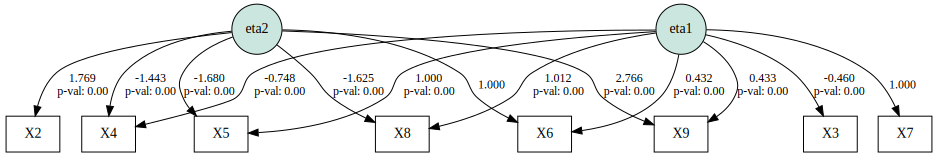

In [5]:
semopy.semplot(model, "model.png")

## Complete SEM example

SEM example considering both the measurement part and structural part in semopy (data and model provided at https://semopy.com/tutorial.html). This example presents a model where three factors are estimated from the data, where each measurement loads only into one factor. The first part of the model is as noted in section 6 (measurement only). Second part (regrssions) reports the structural relationships between factors, and the last part reports potential correlations between the error in each measure (this could be use in section 6 to improve final model). 

In [6]:
import semopy
import pandas as pd
desc = semopy.examples.political_democracy.get_model()
print(desc)

# measurement model
ind60 =~ x1 + x2 + x3
dem60 =~ y1 + y2 + y3 + y4
dem65 =~ y5 + y6 + y7 + y8
# regressions
dem60 ~ ind60
dem65 ~ ind60 + dem60
# residual correlations
y1 ~~ y5
y2 ~~ y4 + y6
y3 ~~ y7
y4 ~~ y8
y6 ~~ y8


In [7]:
data = semopy.examples.political_democracy.get_data()
mod = semopy.Model(desc)
res = mod.fit(data)

In [8]:
print(mod.inspect())

     lval  op   rval  Estimate  Std. Err    z-value   p-value
0   dem60   ~  ind60  1.482379  0.399024   3.715017  0.000203
1   dem65   ~  ind60  0.571912  0.221383   2.583364  0.009784
2   dem65   ~  dem60  0.837574  0.098446   8.507992       0.0
3      x1   ~  ind60  1.000000         -          -         -
4      x2   ~  ind60  2.180494  0.138565  15.736254       0.0
5      x3   ~  ind60  1.818546  0.151993   11.96465       0.0
6      y1   ~  dem60  1.000000         -          -         -
7      y2   ~  dem60  1.256819  0.182687   6.879647       0.0
8      y3   ~  dem60  1.058174  0.151521   6.983699       0.0
9      y4   ~  dem60  1.265186  0.145151   8.716344       0.0
10     y5   ~  dem65  1.000000         -          -         -
11     y6   ~  dem65  1.185743  0.168908   7.020032       0.0
12     y7   ~  dem65  1.279717  0.159996    7.99841       0.0
13     y8   ~  dem65  1.266084  0.158238   8.001141       0.0
14  dem60  ~~  dem60  3.950849  0.920451   4.292296  0.000018
15  dem6

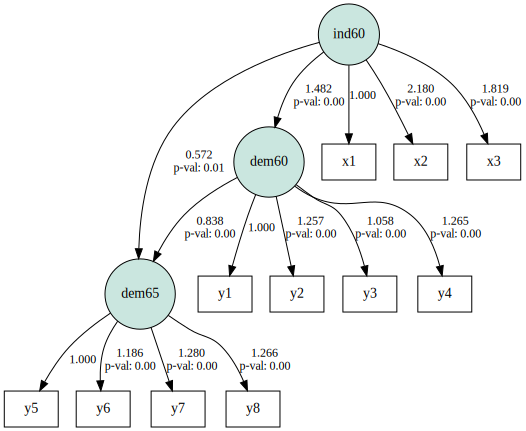

In [9]:
semopy.semplot(mod, "semmodel.png")

<font size="3">**Tarea 4**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 6/12 hasta las 21:00. Utilizar la base de datos *junaeb2.csv*. La base corresponde a observaciones tomadas de estudiantes de colegio. Las variables tienen la siguiente descripcion:

- sexo: sexo del estudiante
- edad: edad del estudiante (meses)
- imce: indice de masa corporal estandarizado
- vive_padre: si el padre vive en el hogar
- vive_madre: si la madre vive en el hogar
- area: urbana=1, rural=0
- sk1: muestra afecto a padres (1: siempre - 5: nunca)
- sk2: muestra afecto a sus pares (1: siempre - 5: nunca)
- sk3: expresa sus sentimientos (1: siempre - 5: nunca)
- sk4: usa gestos para mostrar sentimientos (1: siempre - 5: nunca)
- sk5: juega con otros (1: siempre - 5: nunca)
- sk6: comparte sus cosas con otros (1: siempre - 5: nunca)
- sk7: es agresivo (1: siempre - 5: nunca)
- sk8: participa en juegos grupales (1: siempre - 5: nunca)
- sk9: hace preguntas a adultos (1: siempre - 5: nunca) 
- sk10: tiene interes por libros (1: siempre - 5: nunca) 
- sk11: tiene interes por su entorno (1: siempre - 5: nunca)
- sk12: juega a armar y desarmar cosas (1: siempre - 5: nunca) 
- sk13: tiene expresiones artisticas (1: siempre - 5: nunca) 
- act_fisica: frecuencia actividad fisica (1: nunca - 5: 5 o mas veces a la semana)
- educm: años de escolaridad de la madre
- educp: años de escolaridad del padre
- madre_work: si la madre trabaja (-1: labor domestica, 0: desempleada, 1: empleada)

Preguntas:

1. Cargue la base de datos y realice los ajustes necesarios para su uso (missing values, recodificar variables, etcetera). Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

**R:** Tal como se ha visto en las unidades anteriores, es necesario identificar errores de codificacion en las variables. No se requiere remover missing data (nan), dado que la mayoria de los software convencionales ajustan por ello. Hay variables categoricas no ordinales que es importante identificar (madre_work), y otras ordinales, como aquellas usadas para PCA.

2. Usando las variables sk1-sk13 realice un PCA. En particular, identifique los valores propios y determine el numero optimo de componentes. Luego estime y grafique la distribucion de los componentes. Ademas discuta la importancia relativa de las variables sobre cada uno de los componentes estimados. Que se puede concluir de este analisis?

**R:** El analisis PCA sugiere 3 factores relevantes (en base al scree plot). Como es de esperar, los componentes son ortogonales entre si. Las variables cargan de forma importante en multiples componentes y con diferentes signos, lo cual es esperable dadas las caracteristicas de la data y el metodo (toda la varianza se usa en PCA, mientras que EFA solo usa la varianza comun que no es ruido).

3. Con los resultados de la Pregunta 2, mantenga los primeros 3 componentes principales. Graficamente indique si existen diferencias significativas entre grupos usando las siguientes variables: sexo, area, madre_work y act_fisica. Que puede concluir de los resultados?

**R:** En base a los 3 factores mas importantes no se encuentra ninguna asociacion relevante entre las variables predeterminadas y los factores estimados. En general hay sustancial dispersion en base a las distintas categorias en cada caso.

4. A partir del mismo set de variables sk1-sk13 realice un EFA. En particular determine el numero optimo de factores y las variables que se asocian a cada factor. Tambien discuta si existen variables que no son informativas (Hint: para realizar un EFA, todas las variables deben estar representatadas en el mismo sentido logico. Si una carateristica es negativa debe ser invertida en la escala, de tal forma que todas las variables representen aspectos positivos).

**R:** Los resultados sugieren la presencia de 2 factores importantes (o maximo 3 considerando el screeplot y la importancia relativa de cada factor). Los factores no contribuyen a una parte sustancial de la varianza, pero tienen importante carga en preguntas clave. Con ello se puede proponer un modelo CFA con 2 o 3 factores, y el resultado final debe quedar a definir en base a los indicadores de ajuste.

5. Con los resultados obtenidos en la Pregunta 4, proponga un CFA donde cada variable solo se asocia con un factor. Entregue un nombre a cada factor que representa el concepto comun entre todas las variables. Reporte la importancia de cada medida (variable) a cada factor e indique la correlacion entre factores. 

**R:** Como se explica arriba, el modelo CFA con 2 o 3 factores entrega una mirada clara de aquellas preguntas comunes (una pregunta asociada solo a un factor), y muestra ademas importante relacion entre factores. Los criterios de ajuste son buenos en general (RMSEA < 0.05 y CFI/TLI mayor a 0.9). Las definiciones de los factores hacen sentido en cuanto a las preguntas relevantes en cada caso.

6. Finalmente, implemente un SEM completo usando la estructura propuesta en la Pregunta 5. En particular, estime un modelo donde los factores explican el nivel de actividad fisica, junto con otras variables que existen en la base de datos. Ademas utilice otras variables relevantes de la base de datos para explicar los factores latentes. Las variables a incluir en el modelo final deben tener sustento teorico y el modelo final debe optimizar el ajuste a los datos, en base a los criterios vistos en clase. Que puede concluir en base a sus resultados?

**R:** En el modelo que tiene la mejor especificacion en cuanto a criterio de ajuste, variables predeterminadas (exogenas) contribuyen a entender el nivel de actividad fisica, asimismo como los factores, yendo tanto en una asociacion positiva como negativa. Variables prederminadas tambien se asocian con cada uno de los factores de forma independiente. 